
# Приложение для знакомств

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Был ли эксперимент успешен в целом.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

## Данные

Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

users_*.csv – информация о пользователях:

uid – идентификатор пользователя\
age – возраст\
attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки деленные на просмотры и умноженные на 1000) \
coins – число монеток (внутренняя валюта)\
country – страна\
visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)\
gender – пол\
age_filter_start  – фильтр поиска, мин. значение \
age_filter_end  – фильтр поиска, макс. значение \
views_count – число полученных оценок \
was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)\
is_premium –  является ли премиум\
total_revenue – нормированная выручка


transactions_*.csv – информация о платежах пользователей:

uid – идентификатор пользователя\
country – страна\
joined_at – дата и время регистрации\
paid_at – дата и время покупки\
revenue – нормированная выручка\
payment_id – идентификатор платежа\
from_page – откуда пользователь перешел на страницу оплаты\
product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) 


### Основные этапы А/В тестирования:

1. Определение цели.
2. Выбор метрики.
3. Формулировние гипотез.
4. Настройка эксперимента:
 - определить на какую аудиторию запускается тест;
 - проверить репрезентативность выборки в целом и однородность выборок в группах;
 - рассчитать объем выборки и длительность проведения эксперимента
5. Проведение тестирования.
6. Анализ результатов.

###  Этапы А/В тестирования нашей задачи.

Цель - оценить изменения в данных, происходящие при изменении стоимости  премиум-подписки для пользователей из некоторых стран при покупке через две новые платежные системы \
Метрика - ARPU, ARPPU, CR \
Гипотеза - ожидаем, что изменение стоимости премиум-подписки вызовет изменение выручки\
Настройка эксперимента - 

    определены следущие условия:
    -  тест  проведен только для новых пользователей
    -  пользователи распределены по трем группам: тестовая и две контрольные (для проведения А/А теста)
    -  выбраны объем выборки и длительность проведения эксперимента.
    
Распределение пользователей по группам нужно проверить при помощи А/А тестирования. Если пользователи  распределились по группам случайно, то их сравнение не должно дать статистически значимых различий, если  же группы  имеют статистически значимые различия, то  результат А/В тестирования не будет корректен.
    
Анализ результата - описан в конце работы в выводе.

In [131]:
import pandas as pd
import requests
from urllib.parse import urlencode
from datetime import datetime, timedelta
import numpy as np
import pingouin as pg
from scipy.stats import chi2_contingency, ttest_ind, chi2
#import statsmodels.stats.multicomp as sms
import seaborn as sns
import matplotlib.pyplot as plt
#import statsmodels.api as sm 
#from tqdm.auto import tqdm
from scipy.stats import norm

sns.set(rc={'figure.figsize':(6,4)}, style="whitegrid")

In [132]:
# прочитаем данные
url ='https://cloud-api.yandex.net/v1/disk/public/resources/download?'
users_test = 'https://disk.yandex.ru/d/4XXIME4osGrMRA'
users_control_1 = 'https://disk.yandex.ru/d/yJFydMNNGkEKfg'
users_control_2 = 'https://disk.yandex.ru/d/br6KkQupzzTGoQ'
transactions_test = 'https://disk.yandex.ru/d/gvCWpZ55ODzs2g'
transactions_control_1 = 'https://disk.yandex.ru/d/VY5W0keMX5TZBQ'
transactions_control_2 = 'https://disk.yandex.ru/d/th5GL0mGOc-qzg'

# информация о пользователях в тестовой группе
query = requests.get(url + urlencode(dict(public_key = users_test)))
users_test = pd.read_csv(query.json()['href'],sep = ';')

# информация о пользователях в первой контрольной группе
query = requests.get(url + urlencode(dict(public_key = users_control_1)))
users_control_1 = pd.read_csv(query.json()['href'],sep = ';')

# информация о пользователях во второй контрольной группе 
query = requests.get(url + urlencode(dict(public_key = users_control_2)))
users_control_2 = pd.read_csv(query.json()['href'],sep = ';')

# информация о платежах пользователей в тестовой группе
query = requests.get(url + urlencode(dict(public_key = transactions_test)))
transactions_test = pd.read_csv(query.json()['href'],sep = ';')

# информация о платежах пользователей в первой контрольной группе
query = requests.get(url + urlencode(dict(public_key = transactions_control_1)))
transactions_control_1 = pd.read_csv(query.json()['href'],sep = ';')

# информация о платежах пользователей во второй контрольной группе
query = requests.get(url + urlencode(dict(public_key = transactions_control_2)))
transactions_control_2 = pd.read_csv(query.json()['href'],sep = ';')


## Предварительный анализ данных


In [133]:
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [134]:
# смотрим типы данных
users_test.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [135]:
# посчитаем пропущенные значения
users_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [136]:
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [137]:
# смотрим типы данных
users_control_1.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [138]:
# посчитаем пропущенные значения
users_control_1.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4280
country                0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3904
is_premium          4148
total_revenue          0
dtype: int64

In [139]:
users_control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [140]:
# смотрим типы данных
users_control_2.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [141]:
# посчитаем пропущенные значения
users_control_2.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4203
country                0
visit_days          1364
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3853
is_premium          4073
total_revenue          0
dtype: int64

In [142]:
# сравним количество строк в таблицах users* и количество уникальных пользователей в них
print(f' users_test      - строк', 
      users_test.shape[0], ' ун.пользователей', users_test.uid.nunique(),'\n','users_control_1 - строк',
      users_control_1.shape[0], ' ун.пользователей', users_control_1.uid.nunique(),'\n','users_control_2 - строк', 
      users_control_2.shape[0],' ун.пользователей', users_control_2.uid.nunique())


 users_test      - строк 4308  ун.пользователей 4308 
 users_control_1 - строк 4340  ун.пользователей 4340 
 users_control_2 - строк 4264  ун.пользователей 4264


Дубликатов пользователей в таблицах users* нет

In [143]:
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [144]:
# смотрим типы данных
transactions_test.dtypes

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
dtype: object

In [145]:
# посчитаем пропущенные значения
transactions_test.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [146]:
transactions_control_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [147]:
# смотрим типы данных
transactions_control_1.dtypes

uid             float64
country          object
joined_at        object
paid_at          object
revenue         float64
payment_id      float64
from_page        object
product_type     object
dtype: object

In [148]:
# посчитаем пропущенные значения
transactions_control_1.isna().sum()

uid             630
country         630
joined_at         0
paid_at           0
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [149]:
transactions_control_2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [150]:
# смотрим типы данных
transactions_control_2.dtypes

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
dtype: object

In [151]:
# посчитаем пропущенные значения
transactions_control_2.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [152]:
#найдем количество строк
print(f'transactions_test -  ',transactions_test.shape[0], ', transactions_control_1 - ',
      transactions_control_1.shape[0], ', transactions_control_2 - ', transactions_control_2.shape[0])   

transactions_test -   273 , transactions_control_1 -  1007 , transactions_control_2 -  328


Данные датасета  transactions_control_1 отличаются от двух других transactions: типом данных, наличием пустых значений и количеством строк.\
Изменим тип данных колонок с float на int и удалим пустые значения

In [153]:
# удаляем пустые строки
transactions_control_1 = transactions_control_1.dropna()

In [154]:
# теперь сравним количество строк в таблицах transactions* и количество уникальных пользователей в них
print(f' transactions_test      - строк', 
      transactions_test.shape[0], ' ун.пользователей', transactions_test.uid.nunique(),'\n',
                                  'transactions_control_1 - строк',
      transactions_control_1.shape[0], ' ун.пользователей', transactions_control_1.uid.nunique(),'\n',
                                  'transactions_control_2 - строк', 
      transactions_control_2.shape[0],' ун.пользователей', transactions_control_2.uid.nunique())

 transactions_test      - строк 273  ун.пользователей 146 
 transactions_control_1 - строк 377  ун.пользователей 193 
 transactions_control_2 - строк 328  ун.пользователей 187


В таблицах transactions* строк больше, чем уникальных пользователей, т.е. на одного пользователя может приходится несколько транзакций.

In [155]:
# меняем тип 
transactions_control_1.revenue = transactions_control_1.revenue.astype('int')
transactions_control_1.payment_id = transactions_control_1.payment_id.astype('int')
transactions_control_1.uid = transactions_control_1.uid.astype('int')

# проверяем типы данных
transactions_control_1.dtypes

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
dtype: object

Изменим тип данных колонок joined_at и paid_at на to_datetime

In [156]:
transactions_test.joined_at = pd.to_datetime(transactions_test['joined_at'])
transactions_test.paid_at = pd.to_datetime(transactions_test['paid_at'])


transactions_control_1.joined_at = pd.to_datetime(transactions_control_1['joined_at'])
transactions_control_1.paid_at = pd.to_datetime(transactions_control_1['paid_at'])

transactions_control_2.joined_at = pd.to_datetime(transactions_control_2['joined_at'])
transactions_control_2.paid_at = pd.to_datetime(transactions_control_2['paid_at'])



# Предобработка данных

Объединим данные трех таблиц users в одну общую, и добавим в нее колонку для указания первоначальной таблицы  данных. 

In [157]:
users_test['group'] = 'test'
users_control_1['group'] = 'control_1'
users_control_2['group'] = 'control_2'
users = pd.concat([users_test, users_control_1, users_control_2])

In [158]:
users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,test
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,test
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,test


In [159]:
# проверка
users.groupby('group').size()

group
control_1    4340
control_2    4264
test         4308
dtype: int64

при объединении таблиц данные не потерялись

In [160]:
# проверим не повторялись ли пользователи в разных таблицах users*
print(f'строк', users.shape[0], ' ун.пользователей', users.uid.nunique())

строк 12912  ун.пользователей 12912


Определим сколько дней каждый пользователь посещал приложение.

In [161]:
# Преобразуем колонку visit_days к типу строка:
users ['visit_days'] = users.visit_days.astype('str')

# создадим новую колонку и поместим в нее количество дней посещения приложения
users['visit_len'] = users['visit_days'].apply(lambda x:  int(len(x.split(","))) if x != 'nan' else 0)

При проведении  эксперимента  желательно, чтобы влияние эксперимента на контрольную и тестовую группу было сбалансировано. По условию была изменена стоимость премиум подписки для пользователей из нескольких стран, поэтому в тестовой группе у нас находятся только пользователи из стран, которым изменили стоимость премиум подписки. Не логично сравнивать поведение пользователей тестовой группы и пользователей  контрольных групп, если они  из разных стран. Для корректного тестирования и объективной оценки результата  набор стран в контрольных группах должен соответствовать набору стран тестовой группы.

In [162]:
# определим страны, пользователи из которых присутствуют в тестовой группе
test_country = users_test.groupby('country', as_index = False).agg({'uid':'count'})

# в общей таблице users оставим пользователей только из тех страны, которые есть в тестовой
users = users.merge(test_country['country'], on = 'country')




Также объединим данные трех таблиц transactions в одну общую, и добавим в нее колонку для указания первоначальной таблицы данных.

In [163]:
transactions_test['group'] = 'test'
transactions_control_1['group'] = 'control_1'
transactions_control_2['group'] = 'control_2'
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2])

In [164]:
transactions.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium,test
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium,test
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type,test
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type,test
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium,test


In [165]:
transactions.shape[0]

978

In [166]:
# проверка
transactions.groupby('group').size()

group
control_1    377
control_2    328
test         273
dtype: int64

In [167]:
transactions.groupby('group').uid.nunique()

group
control_1    193
control_2    187
test         146
Name: uid, dtype: int64

при объединении таблиц данные не потерялись

In [168]:
# определим границы платежей
transactions[['joined_at', 'paid_at']].describe()

,joined_at,paid_at
count,978,978
mean,2017-09-04 13:13:16.257668864,2017-09-05 05:21:34.110429440
min,2015-01-19 11:49:00,2016-12-14 16:16:00
25%,2017-08-11 07:00:15,2017-07-11 19:15:15
50%,2017-10-18 19:35:00,2017-10-20 14:28:30
75%,2017-10-24 12:26:30,2017-10-28 16:15:30
max,2017-10-31 23:40:00,2017-12-11 23:28:00


По условию задачи пользователи должны быть новыми, т.е. данные за 2015 и 2016 годы удаляем

In [169]:
transactions=transactions.loc[transactions.joined_at >= '2017-01-01']

In [170]:
transactions.shape[0]

975

Количество транзакции существенно не изменилось

In [171]:
# посмотрим нет ли у нас оплат до регистрации пользователей
transactions.query('paid_at < joined_at' )

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
11,891861048,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588,68,none,premium_no_trial,test
20,891806280,United States of America,2017-10-27 08:56:00,2017-03-11 10:57:00,8242,147,trial_vip_popup,trial_premium,test
24,891786216,Spain,2017-10-27 18:20:00,2017-03-11 20:20:00,12818,147,trial_vip_popup,trial_premium,test
25,892057347,France,2017-10-21 23:15:00,2017-08-11 01:56:00,1209,19,none,coins,test
36,891589239,Italy,2017-10-31 14:16:00,2017-09-11 15:44:00,6305,19,empty_likes,coins,test
...,...,...,...,...,...,...,...,...,...
305,891606141,United States of America,2017-10-31 04:43:00,2017-03-11 21:13:00,3783,67,empty_likes,other_type,control_2
313,891691062,Belgium,2017-10-29 16:19:00,2017-05-11 18:35:00,16614,147,popular_users_block,trial_premium,control_2
314,892075512,United States of America,2017-10-21 16:58:00,2017-08-11 12:18:00,9958,147,trial_vip_popup,trial_premium,control_2
315,891722802,United States of America,2017-10-29 02:08:00,2017-05-11 05:49:00,12727,147,trial_vip_popup,trial_premium,control_2


Не учитывать такое количество данных нельзя. Попробуем разобраться.

In [172]:
transactions.paid_at.max() - transactions.paid_at.min() # период между первым и последним платежом

Timedelta('334 days 20:32:00')

In [173]:
transactions.joined_at.max() - transactions.joined_at.min() # период между первой и последней регистрацией

Timedelta('293 days 22:34:00')

Определение длительности теста в проведении А/В тестирования является важным фактором. Проанализировав наши данные получаем с одной стороны длительность эксперимента более 300 дней (не целесообразно), с другой - количество транзакций за период не очень большое. Рассмотрим следующие версии: 
 - для данного тестирования  были не правильно выбраны длительность проведения и/или объем выборки пользователей;
 - в данных есть ошибки.
 
Исходим из того, что имееются ошибки в данных, а длительность эксперимента составляет разумные сроки.

In [174]:
transactions.joined_at.dt.date.value_counts().index

Index([2017-10-21, 2017-05-11, 2017-10-18, 2017-10-29, 2017-10-16, 2017-06-11,
       2017-10-22, 2017-10-30, 2017-10-15, 2017-10-26, 2017-10-23, 2017-10-20,
       2017-10-31, 2017-10-24, 2017-10-19, 2017-02-11, 2017-10-17, 2017-10-25,
       2017-03-11, 2017-10-14, 2017-08-11, 2017-07-11, 2017-10-28, 2017-10-27,
       2017-01-11, 2017-04-11, 2017-09-11, 2017-10-11],
      dtype='object', name='joined_at')

In [175]:
transactions.paid_at.dt.date.value_counts().index

Index([2017-10-23, 2017-06-11, 2017-10-11, 2017-05-11, 2017-04-11, 2017-10-31,
       2017-10-22, 2017-10-29, 2017-10-16, 2017-07-11, 2017-12-11, 2017-08-11,
       2017-11-11, 2017-10-25, 2017-09-11, 2017-03-11, 2017-10-26, 2017-02-11,
       2017-11-14, 2017-11-13, 2017-10-30, 2017-10-28, 2017-10-20, 2017-10-24,
       2017-10-15, 2017-10-19, 2017-10-27, 2017-01-11, 2017-10-21, 2017-10-17,
       2017-10-18, 2017-11-15, 2017-10-14],
      dtype='object', name='paid_at')

В анализируемых данных число 11 встечается чаще других , попробуем  поменять местами значения месяца и дня у дат с числом дней равным 11.

In [176]:
transactions['joined_at'] = transactions.joined_at\
                        .apply(lambda x: pd.to_datetime(x.strftime("%Y-%d-%m, %H:%M:%S")) if x.day == 11 else x )
transactions['paid_at'] = transactions.paid_at\
                        .apply(lambda x: pd.to_datetime(x.strftime("%Y-%d-%m, %H:%M:%S")) if x.day == 11 else x )



In [177]:
# посмотрим остались ли  оплаты, сделанные  до регистрации пользователей
transactions.query('paid_at < joined_at' )

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group


In [178]:
# определим период между первой регистрацией и последней оплатой
(transactions.paid_at.max() - transactions.joined_at.min()).days

32

После исправления ошибок в датах, получаем длительность эксперимента равной 32 дня. Всего уникальных пользователей в наших данных 12912, в среднем новых пользователей в день примерно 404. Платежей за период тестирования 975, в день в среднем около 31, это не очень большая выборка для тестирования.  

In [179]:
# сделаем колонку содержащую только сумму премиум-подписки 

transactions['premium_no_trial'] = transactions.apply(lambda x: x['revenue'] 
                                                    if x['product_type'] == 'premium_no_trial'  else 0, axis = 1)

По условию стоимость премиум подписки изменили для пользователей нескольких стран при покупке через две новые платежные системы. Параметра, который явно обозначает платежную систему у нас нет. Рассмотрев имеющиеся данные можно предположить, что только payment_id  как-то отражает принадлежность к платежной системе.\
Проанализируем данный параметр.

In [180]:
# определим какие  payment_id использовались при платежах с типом премиум подписка
transactions.query('premium_no_trial > 0').groupby(['payment_id','group'], as_index = False)\
                                                  .agg({'uid':'count'})

,payment_id,group,uid
0,0,control_1,2
1,0,control_2,1
2,0,test,1
3,68,control_1,16
4,68,control_2,14
5,68,test,12
6,147,control_1,88
7,147,control_2,92
8,147,test,63


Премиум подписке во всех трех группах соответствует ТРИ payment_id, один из которых равен 0 (похож на ошибочный или отмененный) и на него приходится по 1-2 платежа, на остальные существенно больше. Поподробнее рассмотрим транзакции пользователей, у которых встречается payment_id равный 0.

In [181]:
# определим uid, у которых payment_id = 0 и выведим все строки общей таблицы транзакций, соответствующие этим 
# пользователям

uid_payment_0 = transactions.query('payment_id == 0').uid
transactions.query('uid in @uid_payment_0').sort_values(['uid','paid_at'])

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,premium_no_trial
138,891216033,United States of America,2017-11-07 12:33:00,2017-11-07 12:47:00,6292,0,autoreply_message,premium_no_trial,control_1,6292
269,891216033,United States of America,2017-11-07 12:33:00,2017-11-07 12:47:00,6292,147,autoreply_message,premium_no_trial,control_1,6292
90,891219540,Australia,2017-11-07 10:50:00,2017-11-07 10:58:00,4719,0,none,premium_no_trial,control_2,4719
144,891219540,Australia,2017-11-07 10:50:00,2017-11-07 10:58:00,4719,147,none,premium_no_trial,control_2,4719
152,891725043,United Arab Emirates,2017-10-29 00:49:00,2017-10-29 07:48:00,9217,147,none,premium_no_trial,test,9217
220,891725043,United Arab Emirates,2017-10-29 00:49:00,2017-10-29 07:48:00,9217,0,none,premium_no_trial,test,9217
210,892101909,France,2017-10-21 03:28:00,2017-10-21 03:39:00,6422,147,none,premium_no_trial,control_1,6422
347,892101909,France,2017-10-21 03:28:00,2017-10-21 03:39:00,6422,0,none,premium_no_trial,control_1,6422
156,892101909,France,2017-10-21 03:28:00,2017-10-23 22:32:00,741,146,empty_likes,coins,control_1,0
189,892101909,France,2017-10-21 03:28:00,2017-10-23 22:35:00,923,19,none,coins,control_1,0


Видим, что каждому платежу с payment_id=0 соответствует «нормальный» платеж с теми же uid, суммой, типом платежа и датой-временем платежа совпадающим до секунды. Исключим строки с payment_id=0, тем более что и по условию у нас только две новые платежные системы, которые у нас и получатся. 

In [182]:
transactions = transactions.loc[transactions.payment_id != 0]

#### Анализ таблицы данных users

In [183]:
users.describe(include = 'all')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_len
count,1.288700e+04,12887.000000,12887.000000,169.000000,12887,12887,12887.000000,12887.000000,12887.000000,12887.000000,1253.0,538.0,12887.000000,12887,12887.000000
unique,NaN,NaN,NaN,NaN,51,2129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN
top,NaN,NaN,NaN,NaN,United States of America,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,control_1,NaN
freq,NaN,NaN,NaN,NaN,4407,4016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4330,NaN
mean,8.917568e+08,32.003957,315.288275,692.970414,NaN,NaN,0.955149,26.816482,38.553969,46.322185,1.0,1.0,525.924498,NaN,4.553892
std,1.611763e+06,10.214975,323.482240,7713.620395,NaN,NaN,0.206986,9.448246,15.491764,283.877900,0.0,0.0,5527.972118,NaN,6.222754
min,8.910509e+08,16.000000,0.000000,1.000000,NaN,NaN,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000,NaN,0.000000
25%,8.913563e+08,25.000000,0.000000,6.000000,NaN,NaN,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000,NaN,0.000000
50%,8.917253e+08,30.000000,250.000000,10.000000,NaN,NaN,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000,NaN,2.000000
75%,8.920860e+08,38.000000,529.000000,28.000000,NaN,NaN,1.000000,32.000000,45.000000,21.000000,1.0,1.0,0.000000,NaN,7.000000


In [184]:
#  посчитаем уникальные значения

users.nunique()

uid                 12887
age                    68
attraction_coeff      847
coins                  50
country                51
visit_days           2129
gender                  2
age_filter_start       67
age_filter_end         81
views_count           562
was_premium             1
is_premium              1
total_revenue         292
group                   3
visit_len              32
dtype: int64

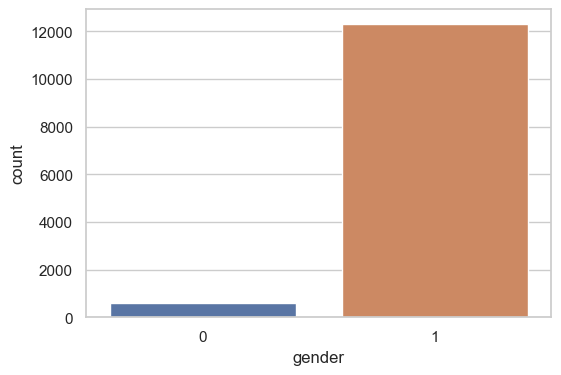

In [259]:
# посмотрим на распределение пользователей  по gender

sns.countplot( x = users['gender'])
plt.show()

По графику видно,что намного больше пользователей с gender=1, будем считать, что это мужчины.


<Axes: xlabel='gender', ylabel='age'>

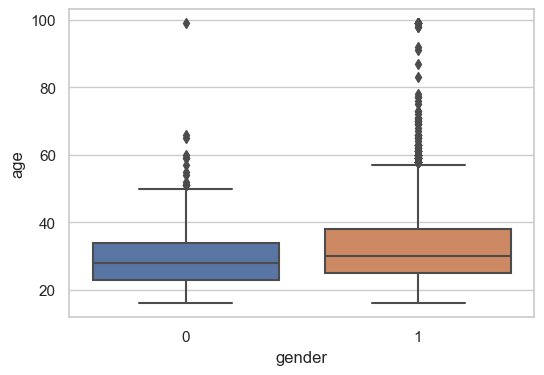

In [260]:
# Посмотрим распределение пользователей по полу и возрасту.

sns.boxplot(x = 'gender', y = 'age', data = users)

Медиана возраста пользователей обоих полов примерно около 30 лет, это значит что половина всех пользователей моложе 30 лет. Есть выбросы на больших значениях возраста и у женщин, и у мужчин - скорее всего это максимально возможный возраст при заполнении данных о возрасте. Т.к. мужчин намного больше, чем женщин, то и различных значений возраста у них больше.

<Axes: xlabel='gender', ylabel='views_count'>

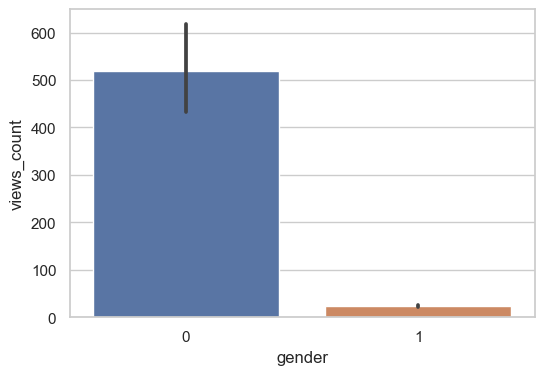

In [261]:
# полученные оценки  в зависимости от пола

sns.barplot(x = 'gender',y = 'views_count', data = users)

<Axes: xlabel='gender', ylabel='attraction_coeff'>

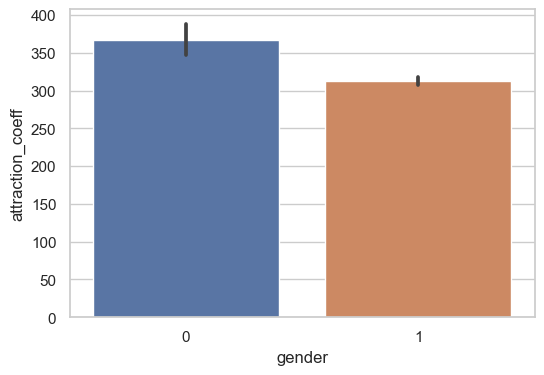

In [262]:
#  коэффициент привлекательности у женщин и мужчин

sns.barplot(x = 'gender',y = 'attraction_coeff', data = users)

Число полученных оценок  женщинами намного больше, чем мужчинами, при этом  коэффициент привлекательности почти не отличается - женщины совсем немного привлекательнее мужчин.


Посмотрим зависит ли средний коэффициет привлекательности от возраста и пола.

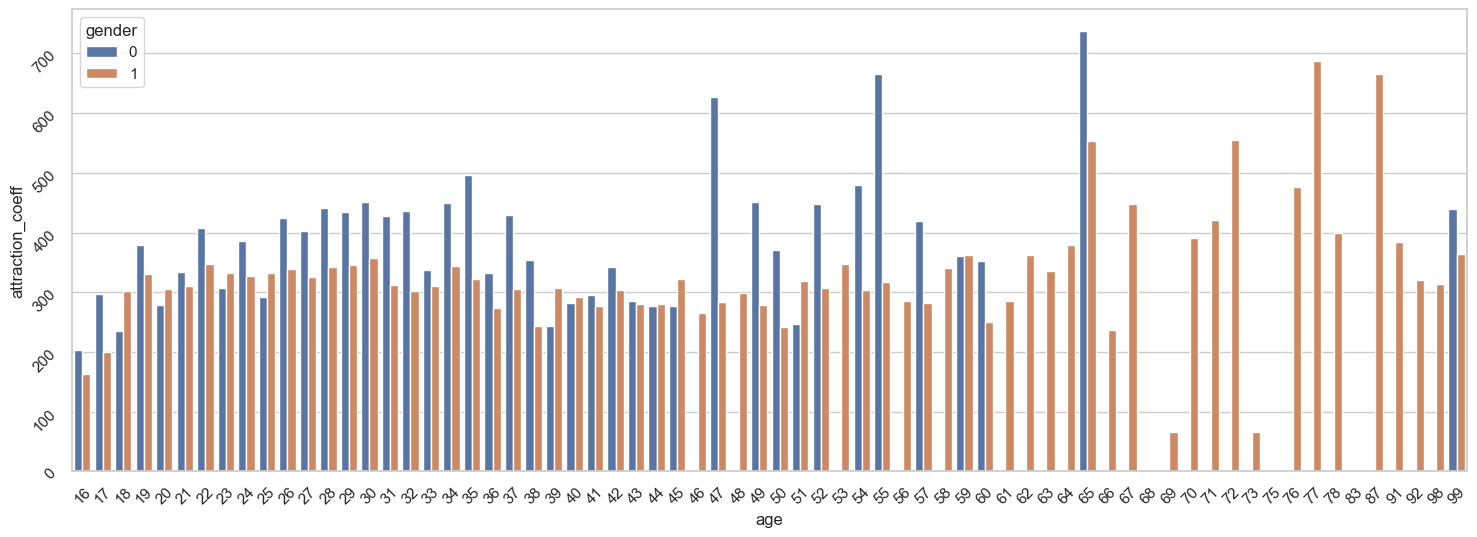

In [330]:
# Посмотрим зависит ли средний коэффициет привлекательности от возраста и пола.

sns.set(rc = {'figure.figsize':(18,6)}, style = "whitegrid")
ax = sns.barplot(x = 'age', y = 'attraction_coeff', data= users.groupby(['age','gender'], as_index = False)\
                 .agg({'attraction_coeff':'mean'}).astype({'gender':'str'}),hue = 'gender' ) 
                
ax.tick_params(labelrotation = 45)

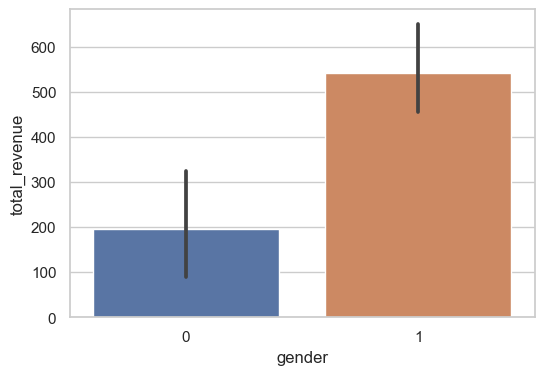

In [333]:
# зависимость средних трат от gender

sns.barplot(x = 'gender', y = 'total_revenue', data = users) 
sns.set(rc={'figure.figsize':(6,4)}, style="whitegrid")

## Метрики

Для бизнеса всегда самым важным является увеличение прибыли, а следовательно и выручки. Поэтому чаще всего изменения в продукте направлены либо непосредственно на увеличение выручки, либо на привлечение новых клиентов, или на вовлечение уже имеющихся пользователей в более активные действия с продуктом, что в конце все равно сказывается на финансах. К внесению изменений надо подходить обдумано, не редко при изменении одного параметра происходят изменения и в ряде других. Оценивая влияние изменения цены премиум подписки на выручку будем использовать следующие метрики: 
 - ARPU (Average revenue per user) - cредний доход с каждого пользователя; 
 - CR - отношение числа платящих пользователей к общему числу пользователей;
 - ARPPU - cредний доход на платящего пользователя.\
 А также посмотрим какое влияние оказало изменение цены премиум подписки на ее покупателей:
 - Конверсия в покупку премиум подписки;
 - Средний доход с покупателя премиум подписки.

## Проверка валидности эксперимента

Для получения корректных результатов А/В тестирования должны быть соблюдены условия однородности выборок. Если бы А/В тестирование мы проводили сами, то должны были разработать адекватную систему сплитования и распределять пользователей по группам с ее помощью. На данном этапе мы можем лишь проверить однородно ли распределены пользователи в наших группах по параметрам пола, возраста и стране проживания. Если пользователи распределились по группам случайно, то их сравнение не должно дать статистически значимых различий.\
Рассмотрим предположения как распределены пользователи в группах по полу, возрасту и стране проживания.

### 1 Пользователи трех групп по параметру пола распределены однородно

<Axes: xlabel='gender', ylabel='uid'>

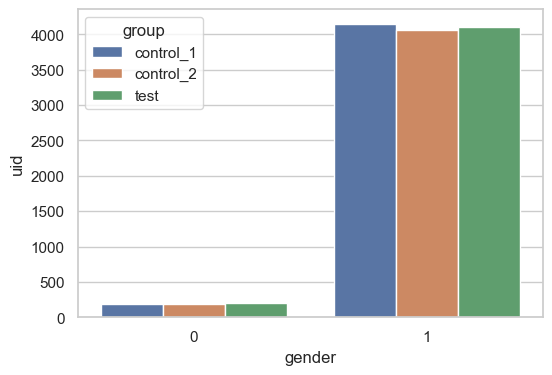

In [334]:
# распределение в группах по полу
sns.barplot(x = 'gender', y = 'uid', data = users.groupby(['gender','group'], as_index = False).uid.count(), 
            hue = 'group') 

Из графика мы видим, что данные распределены однородно по полу. Проверим нашу гипотезу с помощью статистического теста.

Есть две категориальные переменные → нужен хи-квадрат
- $H_0$: нет различия в распределение пола пользователей в группах
- $H_1$: есть различия 

In [266]:
pd.crosstab(users.group, users.gender)

gender,0,1
group,,
control_1,182,4148
control_2,194,4055
test,202,4106


In [267]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users.group, users.gender)) 

In [268]:
stat, p 

(1.285467490855563, 0.5258529093196151)

Интерпретируем результат:

In [269]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [270]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0



Вывод: значение p-value сильно больше уровня значимости. Нулевая гипотеза НЕ ОТКЛОНЯЕТСЯ - нет различия в распределение пола пользователей в группах. Это означает, что  соотношение между мужчинами и женщинами в группах не изменилось, т.е. пользователи трех групп по параметру пола распределены однородно.

### 2  Пользователи трех групп по параметру страна проживания распределены однородно

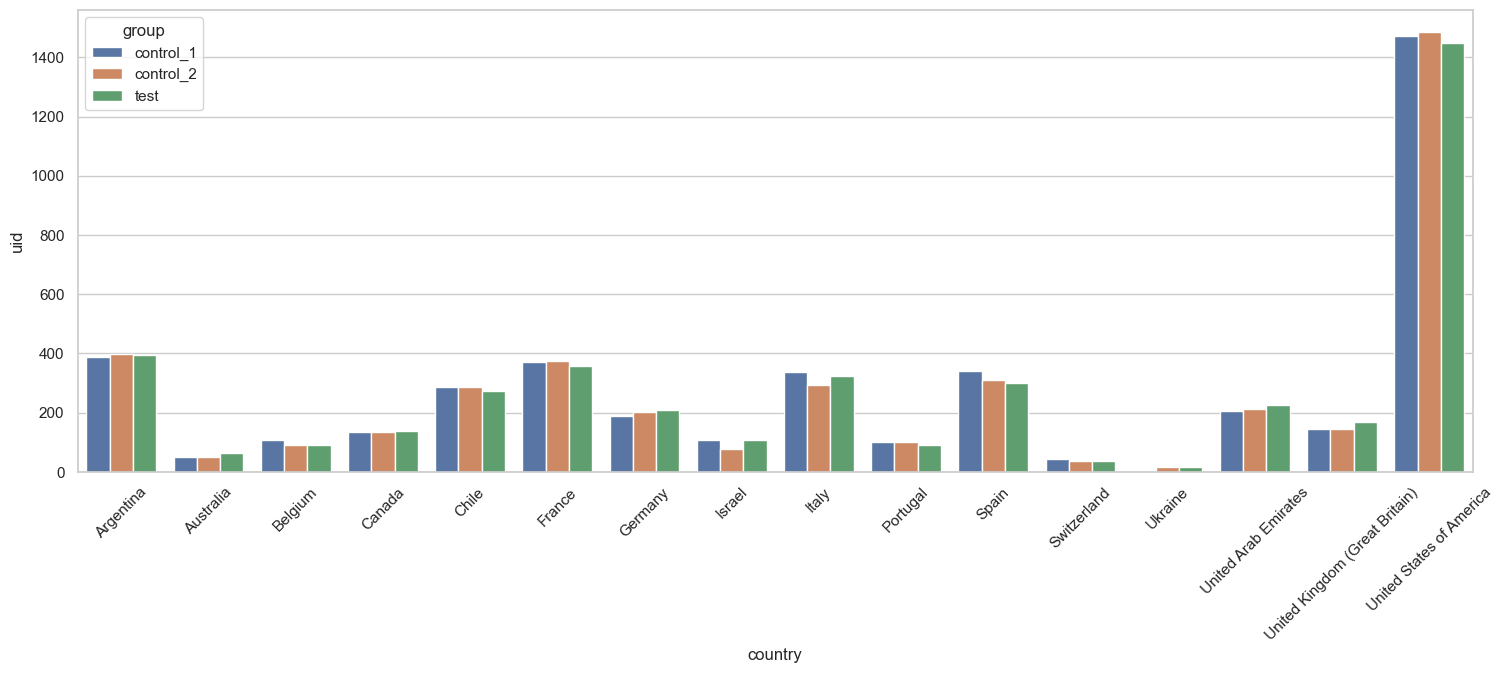

In [347]:
# распределение в группах по странам
sns.barplot(x ='country', y = 'uid', data = users.groupby(['country','group'], as_index = False)\
                                                  .uid.count().query('uid > 10'), hue = 'group')
plt.xticks(rotation = 45)
plt.show()
sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

Из графика мы видим, что пользователи распределены однородно по странам. Проверим гипотезу с помощью статистического теста.

Есть две категориальные переменные → нужен хи-квадрат
- $H_0$: в группах нет различия в распределение пользователей по странам
- $H_1$: есть различия

In [272]:
pd.crosstab(users.group, users.country)

country,Algeria,Argentina,Australia,Azerbaijan,Belgium,Bolivia,Brazil,Canada,Chile,Colombia,...,Switzerland,Tajikistan,Tunisia,Turkey,Ukraine,United Arab Emirates,United Kingdom (Great Britain),United States of America,Uruguay,Uzbekistan
group,,,,,,,,,,,,,,,,,,,,,
control_1,2,389,50,0,108,0,0,134,287,1,...,42,0,3,8,8,207,146,1471,0,0
control_2,0,397,51,0,90,0,0,134,286,2,...,35,1,0,5,18,211,146,1486,1,0
test,2,396,62,1,92,1,1,137,272,1,...,35,2,3,5,15,226,169,1450,1,1


In [273]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users.group, users.country)) 

In [274]:
stat, p

(90.38387596388108, 0.743932591972031)

Интерпретируем результат:

In [275]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [276]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Вывод: значение p-value сильно больше уровня значимости. Нулевая гипотеза НЕ ОТКЛОНЯЕТСЯ -в группах нет различия в распределение пользователей по странам. Это означает, что  соотношение между пользователями из разных стран в группах не изменилось, т.е. пользователи трех групп по параметру  страна проживания распределены однородно.

### 3. Пользователи трех групп по возрасту распределены однородно

<Axes: xlabel='age', ylabel='uid'>

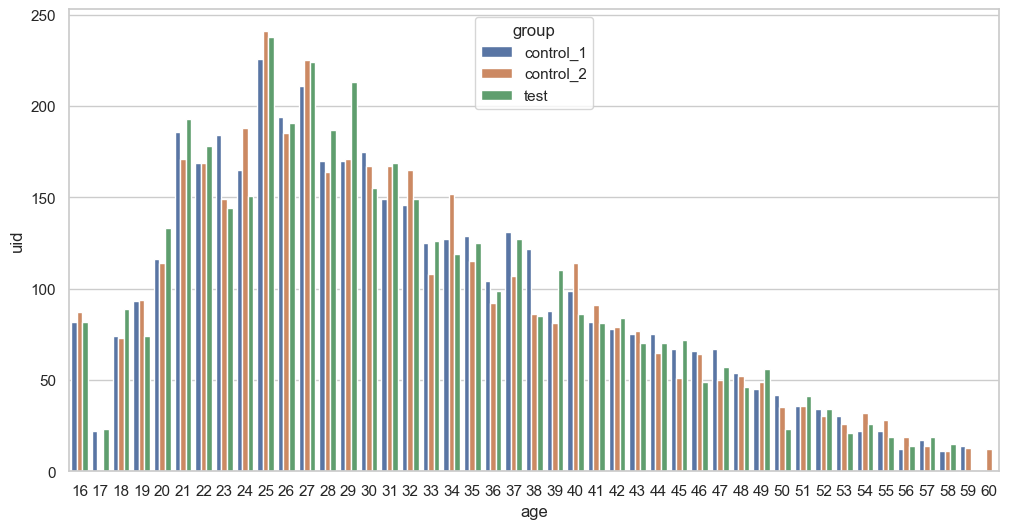

In [348]:
# распределение в группах по возрасту
sns.barplot(x = 'age', y = 'uid', data = users.groupby(['age','group'], as_index = False)\
                                            .uid.count().query('uid > 10'), hue = 'group') 

По графику мы не можем утверждать, что пользователи по возрасту распределены однородно. Проверим нашу гипотезу с помощью статистического теста.

Есть две категориальные переменные → нужен хи-квадрат
- $H_0$: в группах нет различия в распределение пользователей по возрасту
- $H_1$: есть различия 

In [278]:
pd.crosstab(users.group, users.age)

age,16,17,18,19,20,21,22,23,24,25,...,75,76,77,78,83,87,91,92,98,99
group,,,,,,,,,,,,,,,,,,,,,
control_1,82,22,74,93,116,186,169,184,165,226,...,1,0,0,0,0,0,1,0,1,7
control_2,87,9,73,94,114,171,169,149,188,241,...,0,0,1,1,0,1,0,1,0,2
test,82,23,89,74,133,193,178,144,151,238,...,0,1,1,0,1,0,0,0,1,7


In [279]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users.group, users.age)) 

In [280]:
stat, p

(152.64549300635585, 0.1291694634976875)

Интерпретируем результат:

In [281]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [282]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Вывод: значение p-value больше уровня значимости. Нулевая гипотеза НЕ ОТКЛОНЯЕТСЯ - в группах нет различия в распределение пользователей по возрасту. Это означает, что соотношение между пользователями разного возраста в группах не изменилось, т.е. пользователи трех групп по возрасту распределены однородно.



Статистически значимых различий пользователей в выборках нет. С помощью статистических тестов мы подтвердили однородность пользователей в трех группах по параметрам возраста, пола и стране проживания. 

Подготовим данные 

In [283]:
# объединим таблицы с информацией о пользователях и их платежах

df = users.merge(transactions, on = ['uid','country','group'], how = 'left')

## A/A тестирование

А/А тест проводится для подтверждения однородности групп. Определим однородны ли данные двух контрольных групп, сравнивая значения метрик в них. Если обнаружатся статистически значимые различия в рамках А/А теста, то это значит, что какой-то фактор влияет на наши данные помимо изменения стоимости премиум-подписки и доверять результатам А/В теста будет нельзя.

In [284]:
#  данные для А/А тестирования

df_c1_c2 = df.groupby(['uid','group'], as_index = False)\
            .agg({'revenue':'sum'}).query('group == "control_2" or group == "control_1"')


In [285]:
df_c1_c2.head()

,uid,group,revenue
0,891050916,control_2,0.0
1,891050997,control_1,0.0
2,891051075,control_2,0.0
4,891051552,control_1,0.0
5,891051606,control_1,0.0


In [286]:
df_c1_c2.shape

(8579, 3)

### ARPU - средний доход на одного пользователя

In [287]:
# среднее в группах на пользователя

df_c1_c2.groupby(['group'], as_index = False).revenue.mean()

,group,revenue
0,control_1,600.182679
1,control_2,444.995293


In [288]:
# проверяем на гомогенность дисперсий

pg.homoscedasticity(data = df_c1_c2, dv = "revenue", group = "group")

,W,pval,equal_var
levene,1.419894,0.233454,True


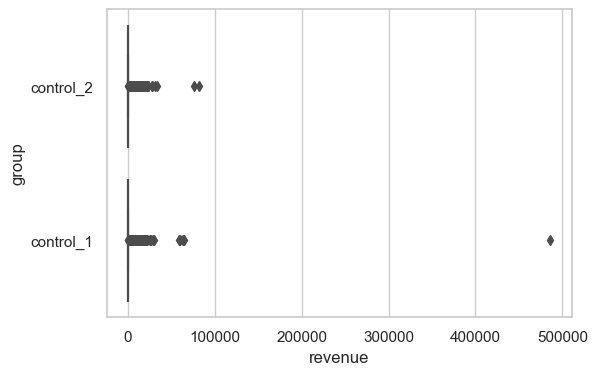

In [354]:
sns.boxplot(data = df_c1_c2, x = "revenue", y = "group")
sns.set(rc={'figure.figsize':(6,4)}, style="whitegrid")

/var/folders/m3/syl5j3ys2v570wpqnv0669s80000gp/T/ipykernel_1712/2406279507.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df_c1_c2.query("group == 'control_1'").revenue,kde = False, bins = 15)
/var/folders/m3/syl5j3ys2v570wpqnv0669s80000gp/T/ipykernel_1712/2406279507.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6

<Axes: xlabel='revenue'>

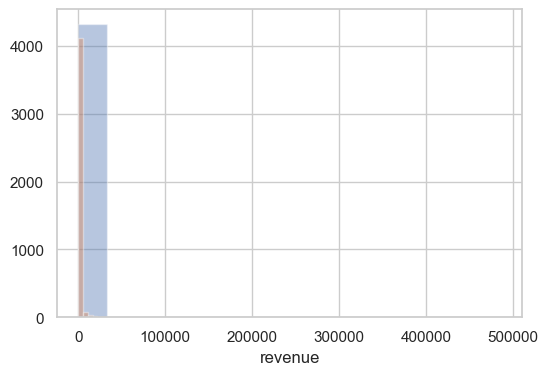

In [353]:
sns.distplot( df_c1_c2.query("group == 'control_1'").revenue,kde = False, bins = 15)
sns.distplot( df_c1_c2.query("group == 'control_2'").revenue,kde = False, bins = 15)

Есть две независимые количественные переменные, дисперсия гомогенна - поэтому проверим равенство средних двух групп с помощью tt- теста:

- $H_0$: нет различий между средними значениями дохода на одного пользователя
- $H_1$: есть различия между средними значениями дохода на одного пользователя

In [291]:
ttest_ind(df_c1_c2.query(' group == "control_2" ').revenue, 
          df_c1_c2.query(' group == "control_1" ').revenue)

TtestResult(statistic=-1.1915929393474503, pvalue=0.2334538656552249, df=8577.0)

Интерпретируем результат: значение p-value больше уровня значимости. Нулевая гипотеза НЕ ОТКЛОНЯЕТСЯ - нет статистически значимых различий между средними значениями дохода на одного пользователя в группах .

### ARPPU - cредний доход на платящего пользователя

In [292]:
# средняя сумма на платящего пользователя по группам

df_c1_c2.query('revenue > 0').groupby(['group'], as_index = False).revenue.mean()

,group,revenue
0,control_1,13535.369792
1,control_2,10220.459459


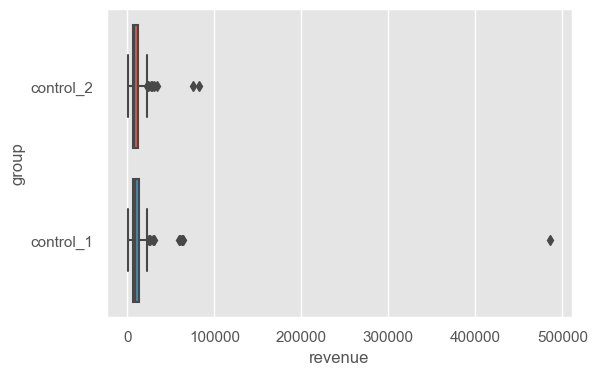

In [344]:
sns.boxplot(data = df_c1_c2.query('revenue  > 0 '), x = "revenue", y = "group");

In [294]:
# проверяем на гомогенность дисперсий

pg.homoscedasticity(data = df_c1_c2.query('revenue > 0'), dv = "revenue", group = "group")

,W,pval,equal_var
levene,1.09788,0.295407,True


Проверим равенство средних двух групп с помощью tt- теста:

- $H_0$: нет различий между средними значениями сумм платящих пользователей
- $H_1$: есть различия между средними значениями сумм платящих пользователей

In [295]:
ttest_ind(df_c1_c2.query(' group == "control_2" and revenue  > 0')\
             .revenue , df_c1_c2.query(' group == "control_1" and revenue  > 0').revenue )

TtestResult(statistic=-1.2222608918056561, pvalue=0.22237666838777864, df=375.0)

Интерпретируем результат: значение p-value больше уровня значимости. Нулевая гипотеза НЕ ОТКЛОНЯЕТСЯ -  нет статистически значимых различий между средним доходом на платящих пользователей в двух контрольных группах.

### CR - отношение числа платящих пользователей к общему числу пользователей

In [296]:
# покупал или нет 
df_c1_c2['buy'] = df_c1_c2.apply(lambda x: 1 if x['revenue'] > 0   else 0, axis = 1 )

In [297]:
pd.crosstab(df_c1_c2.group, df_c1_c2.buy)

buy,0,1
group,,
control_1,4138,192
control_2,4064,185


- $H_0$: распределение платящих пользователей не зависит от группы
- $H_1$: зависит

In [298]:
tat, p, dof, expected = chi2_contingency(pd.crosstab(df_c1_c2.group, 
                                                      df_c1_c2.buy),correction=False)

In [299]:
tat, p

(0.03284399196746994, 0.8561877428449565)

Значение p-value  больше уровня значимости. Нулевая гипотеза НЕ ОТКЛОНЯЕТСЯ - распределение платящих пользователей не зависит от группы. Это означает, что конверсия в покупку  в группах не изменилось.

Вывод: сравнивая метрики мы определили, что данные двух контрольных групп однородны. Статистически значимых различий в рамках А/А теста не обнаружено - можно проводить  А/В тест.

# А/В тестирование

По условию у нас есть одна тестовая и две контрольные группы, поэтому мы можем провести тестирование используя любую из контрольных групп, например control_2. 

In [300]:
# подготовим данные для А/B тестирования

df_t_c2 = df.groupby(['uid','group'], as_index = False)\
            .agg({'revenue':'sum'}).query('group == "test" or group == "control_2"')

In [301]:
df_t_c2.head()

,uid,group,revenue
0,891050916,control_2,0.0
2,891051075,control_2,0.0
3,891051147,test,0.0
6,891051960,control_2,0.0
7,891052416,control_2,0.0


In [302]:
df_t_c2.shape

(8557, 3)

### ARPU - средний доход на одного пользователя

Гипотеза - средний доход на одного пользователя изменился

In [303]:
# среднее в группах на пользователя

df_t_c2.groupby(['group'], as_index = False).revenue.mean()

,group,revenue
0,control_2,444.995293
1,test,542.173630


In [304]:
# проверяем на гомогенность дисперсий

pg.homoscedasticity(data = df_t_c2, dv = "revenue", group = "group")

,W,pval,equal_var
levene,1.442905,0.229703,True


<Axes: xlabel='revenue', ylabel='group'>

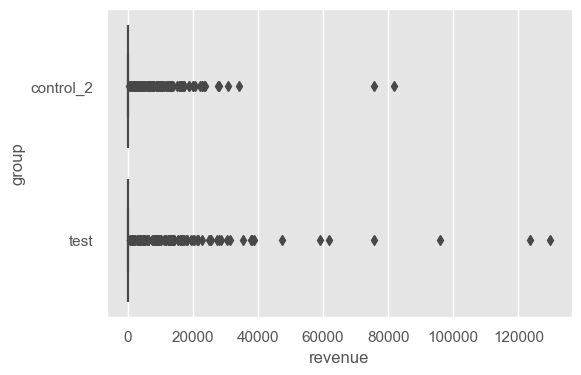

In [343]:
sns.boxplot(data=df_t_c2, x = "revenue", y = "group")

/var/folders/m3/syl5j3ys2v570wpqnv0669s80000gp/T/ipykernel_1712/4079444891.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df_t_c2.query("group == 'test'").revenue,kde = False, bins = 15)
/var/folders/m3/syl5j3ys2v570wpqnv0669s80000gp/T/ipykernel_1712/4079444891.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750

<Axes: xlabel='revenue'>

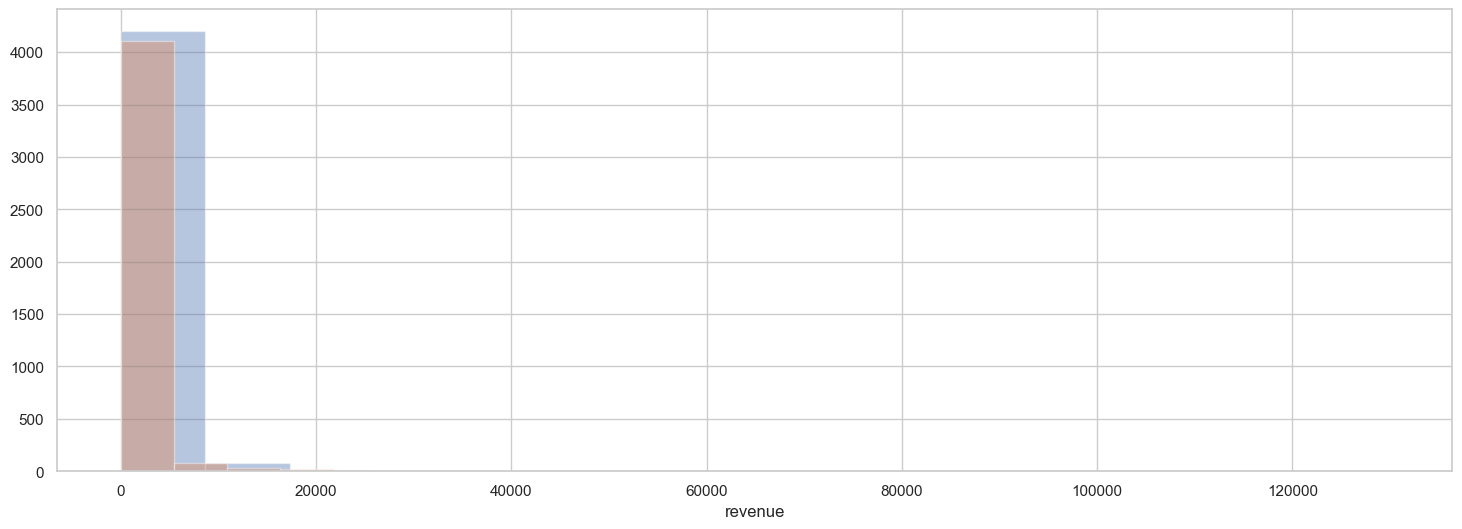

In [306]:
sns.distplot( df_t_c2.query("group == 'test'").revenue,kde = False, bins = 15)
sns.distplot( df_t_c2.query("group == 'control_2'").revenue,kde = False, bins = 15)


Есть две независимые количественные переменные, дисперсия гомогенна - поэтому проверим равенство средних двух групп с помощью tt- теста:

- $H_0$: нет различий между средними значениями данных
- $H_1$: есть различия между средними значениями данных

In [307]:
ttest_ind(df_t_c2.query(' group == "control_2" ').revenue, 
          df_t_c2.query(' group == "test" ').revenue)

TtestResult(statistic=-1.2012099602465618, pvalue=0.22970302112044222, df=8555.0)

Значение p-value больше уровня значимости. Нулевая гипотеза НЕ ОТКЛОНЯЕТСЯ -  средний доход на одного пользователя не различается статистически значимо в группах. 

### ARPPU - cредний доход на платящего пользователя

Гипотеза - средний доход на покупателя изменился

In [308]:
# средняя сумма на платящего пользователя по группам

df_t_c2.query('revenue > 0').groupby(['group'], as_index = False).revenue.mean()

,group,revenue
0,control_2,10220.459459
1,test,15997.835616


<Axes: xlabel='revenue', ylabel='group'>

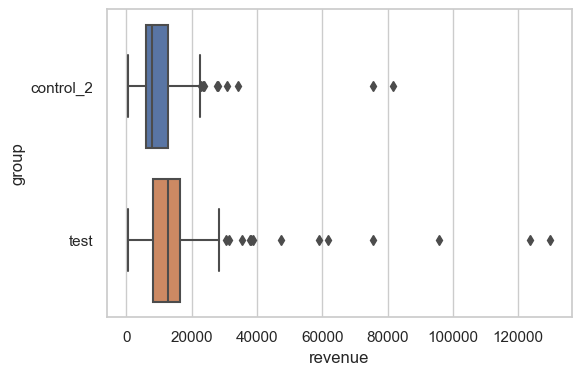

In [338]:
sns.boxplot(data = df_t_c2.query('revenue > 0 '), x = "revenue", y = "group")

<Axes: xlabel='group', ylabel='revenue'>

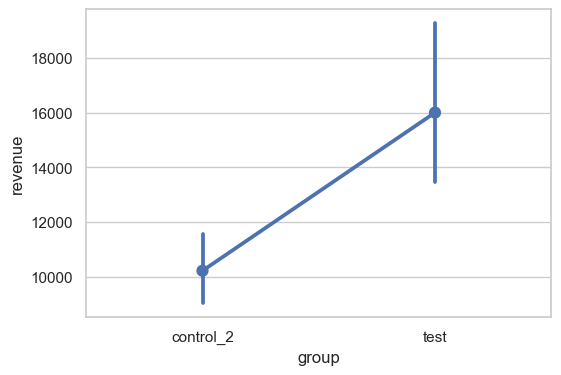

In [339]:
sns.pointplot(data = df_t_c2.query('revenue > 0 '), y = "revenue", x = "group")

In [311]:
# проверяем на гомогенность дисперсий

pg.homoscedasticity(data = df_t_c2.query('revenue > 0'), dv = "revenue", group = "group")

,W,pval,equal_var
levene,5.514844,0.019447,False


Проверим равенство средних двух групп с помощью bootstrap:

- $H_0$: нет различий между средними значениями сумм на платящего пользователя
- $H_1$: есть различия 

In [312]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

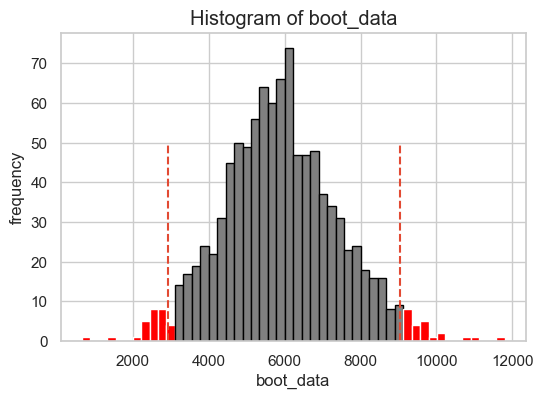

In [340]:
res=get_bootstrap(
    df_t_c2.query(' group == "test" and revenue  > 0').revenue, # числовые значения первой выборки
    df_t_c2.query(' group == "control_2" and revenue  > 0').revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [314]:
# доверительный интервал

res["quants"] 

,0
0.025,2992.185405
0.975,8810.147432


In [315]:
# p_value

res["p_value"]  

0.00010175899426649638

Интерпретируем результат: значение p-value меньше уровня значимости. Нулевая гипотеза  ОТКЛОНЯЕТСЯ - есть статистически значимые различия между средним доходом на покупателя тестовой и контрольной групп. Средняя сумма на платящего пользователя в тестовой группе увеличилась.

### CR - отношение числа платящих пользователей к общему числу пользователей

Гипотеза - конверсия в покупку изменилась

In [316]:
# новая колонка - покупали или нет 
df_t_c2['buy'] = df_t_c2.apply(lambda x: 1 if x['revenue'] > 0   else 0, axis = 1 )

In [317]:
pd.crosstab(df_t_c2.group, df_t_c2.buy)

buy,0,1
group,,
control_2,4064,185
test,4162,146


- $H_0$: нет различия в распределение платящих пользователей
- $H_1$: есть различия

In [318]:
tat, p, dof, expected = chi2_contingency(pd.crosstab(df_t_c2.group, 
                                                      df_t_c2.buy),correction = False)

In [319]:
tat, p

(5.356136972868674, 0.020649466064658846)

Значение p-value меньше уровня значимости. Нулевая гипотеза ОТКЛОНЯЕТСЯ - есть различия в распределение платящих пользователей. Это означает, что конверсия в покупку  в группах изменилась. В тестовой группе количество покупателей уменьшилось.

Получили, что при изменении стоимости премиум-подписки  статистически значимого изменения ARPU не произошло. При этом средняя выручка на платящего пользователя статистически значимо изменилась - увеличилась, а количество пользователей сделавших покупки уменьшилось. Изменилась ли при этом средняя стоимость премиум-подписки по анализируемым метрикам однозначно определить нельзя, поэтому рассмотрим еще метрики:
 - Конверсия в покупку премиум подписки
 - Средний доход с покупателя премиум подписки


### Средний доход с покупателя премиум подписки

Гипотеза - средний доход с покупателя премиум подписки изменился

In [320]:
# подготовим данные 

df_t_c2_premium = df.groupby(['uid','group'], as_index = False)\
            .agg({'premium_no_trial':'sum'}).query('group == "test" or group == "control_2"')

In [321]:
# средняя сумма премиум подписки по группам

df_t_c2_premium.query('premium_no_trial > 0').groupby(['group'], as_index = False).premium_no_trial.mean()

,group,premium_no_trial
0,control_2,7287.465347
1,test,11962.522388


<Axes: xlabel='premium_no_trial', ylabel='group'>

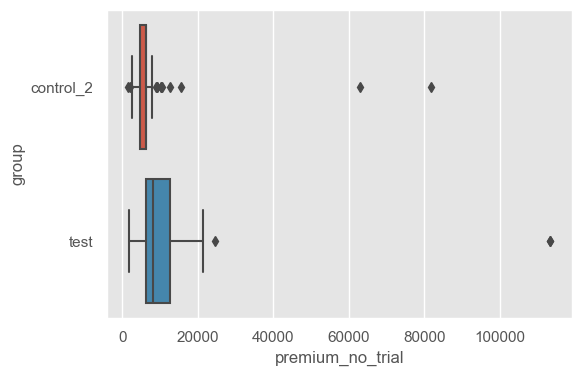

In [341]:
sns.boxplot(data = df_t_c2_premium.query('premium_no_trial > 0 '), x = "premium_no_trial", y = "group")

<Axes: xlabel='group', ylabel='premium_no_trial'>

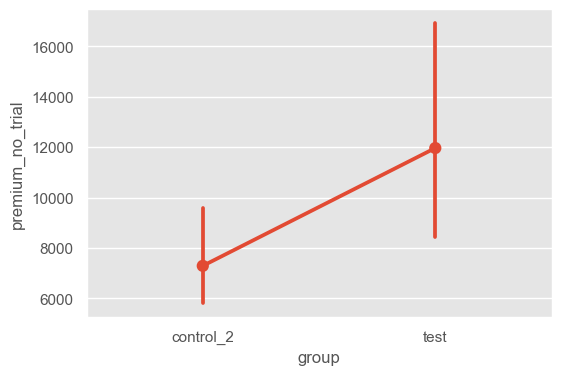

In [342]:
sns.pointplot(data = df_t_c2_premium.query('premium_no_trial > 0 '), y = "premium_no_trial", x = "group")

In [324]:
# проверяем на гомогенность дисперсий

pg.homoscedasticity(data = df_t_c2_premium.query('premium_no_trial > 0'), dv = "premium_no_trial", group = "group")

,W,pval,equal_var
levene,2.659569,0.104824,True


Проверим равенство средних двух групп с помощью tt- теста:

- $H_0$: нет различий между средними значениями сумм премиум подписки
- $H_1$: есть различия между средними значениями сумм премиум подписки

In [325]:
ttest_ind(df_t_c2_premium.query(' group == "test" and premium_no_trial > 0')\
             .premium_no_trial, df_t_c2_premium.query(' group == "control_2" and premium_no_trial > 0').premium_no_trial)

TtestResult(statistic=2.156044570931175, pvalue=0.03251995036123291, df=166.0)

Интерпретируем результат: значение p-value меньше уровня значимости. Нулевая гипотеза ОТКЛОНЯЕТСЯ - есть статистически значимые различия между средним доходом с покупателя премиум подписки тестовой и контрольной групп. По условию задачи было сказано, что стоимость премиум подписки изменилась, теперь можно уточнить - в тестовой группе доход с покупателя премиум подписки увеличился по сравнению с контрольной.

### Конверсия в покупку премиум подписки 

Гипотеза - конверсия в покупку премиум подписки изменилась

In [326]:
# новая колонка - покупали или нет премиум подписку
df_t_c2_premium['premium_buy'] = df_t_c2_premium.apply(lambda x: 1 if x['premium_no_trial'] > 0   else 0, axis = 1 )

In [327]:
pd.crosstab(df_t_c2_premium.group, df_t_c2_premium.premium_buy)

premium_buy,0,1
group,,
control_2,4148,101
test,4241,67


- $H_0$: нет различия в распределение пользователей, купивших премиум подписку
- $H_1$: есть различия

In [328]:
tat, p, dof, expected = chi2_contingency(pd.crosstab(df_t_c2_premium.group, 
                                                      df_t_c2_premium.premium_buy),correction = False)

In [329]:
tat, p

(7.505500711794797, 0.006151083751811438)

Значение p-value меньше уровня значимости. Нулевая гипотеза ОТКЛОНЯЕТСЯ - есть различия в распределение пользователей, купивших премиум подписку. Это означает, что конверсия в покупку премиум подписки в группах изменилась. В тестовой группе количество купивших премиум покупку уменьшилось.

Результат проведения А/В теста: при изменении стоимости премиум-подписки при покупке через две новые платежные системы для новых пользователей из нескольких стран статистически значимого изменения ARPU не произошло. При этом средняя выручка на платящего пользователя статистически значимо изменилась - увеличилась (в том числе, и за счет увеличения средней стоимости премиум подписки) , а количество пользователей сделавших покупки уменьшилось (в том числе, и за счет уменьшения количества пользователей купивших премиум подписку).\
В бизнесе главный показатель - это прибыль, поэтому с этой точки зрения можно сказать, что эксперимент не удачен - величина выручки статзначимо не изменилась. Но мы не можем утверждать наверняка, что эффект равен 0 и изменение стоимости премиум-подписки не оказало никакого влияния на ARPU, можем только сказать, что при проведении данного А/В теста не найдены доказательства статистически значимых изменений.



Если есть возможность, то можно попробовать перезапустить А/В тест с большей выборкой, можно попробовать найти лояльную группу пользователей и изменить стоимость премиум подписки только для них, можно уменьшить величину изменения стоимости премиум подписки (в тестовой группе стоимость подписки увеличилась примерно на 60%).